In [1]:
import pandas as pd
import numpy as np

COLUMNS = ['timestamp', 'xAxis', 'yAxis', 'zAxis']
STANDING = pd.read_csv('../Data/Standing_1462486804782.csv', header=None, names=COLUMNS)[:3000]
WALKING = pd.read_csv('../Data/Walking_1462487070722.csv', header=None, names=COLUMNS)[:3000]
RUNNING = pd.read_csv('../Data/Running_1462487326006.csv', header=None, names=COLUMNS)[:3000]
STAIRS = pd.read_csv('../Data/Stairs_1462487242397.csv', header=None, names=COLUMNS)[:3000]
ON_TRAIN = pd.read_csv('../Data/Train_1462518004872.csv', header=None, names=COLUMNS)[:3000]

STANDING.head()

,timestamp,xAxis,yAxis,zAxis
0,1462486804801,0.260968,-0.056862,9.611523
1,1462486804801,0.260968,-0.056862,9.611523
2,1462486804801,0.260968,-0.056862,9.611523
3,1462486804801,0.260968,-0.056862,9.611523
4,1462486804801,0.260968,-0.056862,9.611523


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['timestamp'], activity['xAxis'], 'x Axis')
    plot_axis(ax1, activity['timestamp'], activity['yAxis'], 'y Axis')
    plot_axis(ax2, activity['timestamp'], activity['zAxis'], 'z Axis')
    plt.subplots_adjust(hspace=0.2)
    plt.show()
    

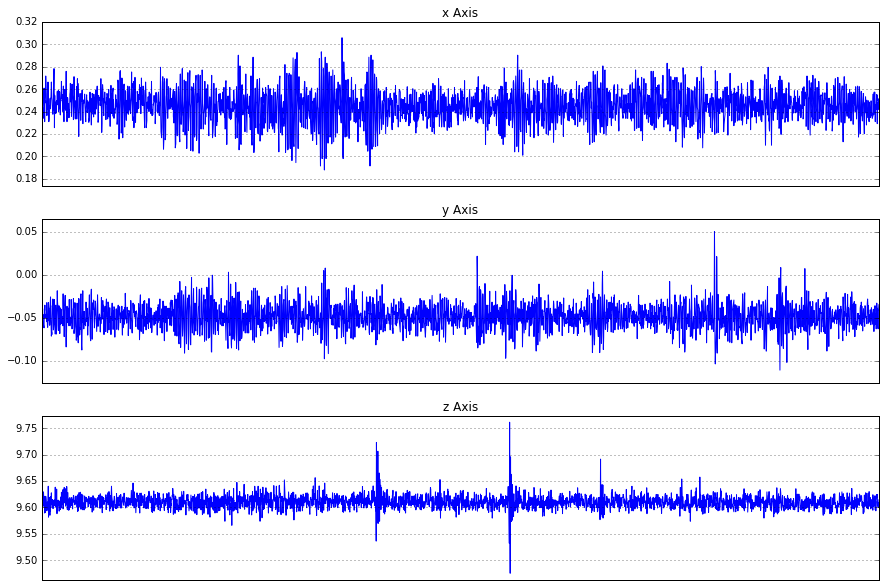

In [3]:
plot_activity(STANDING)

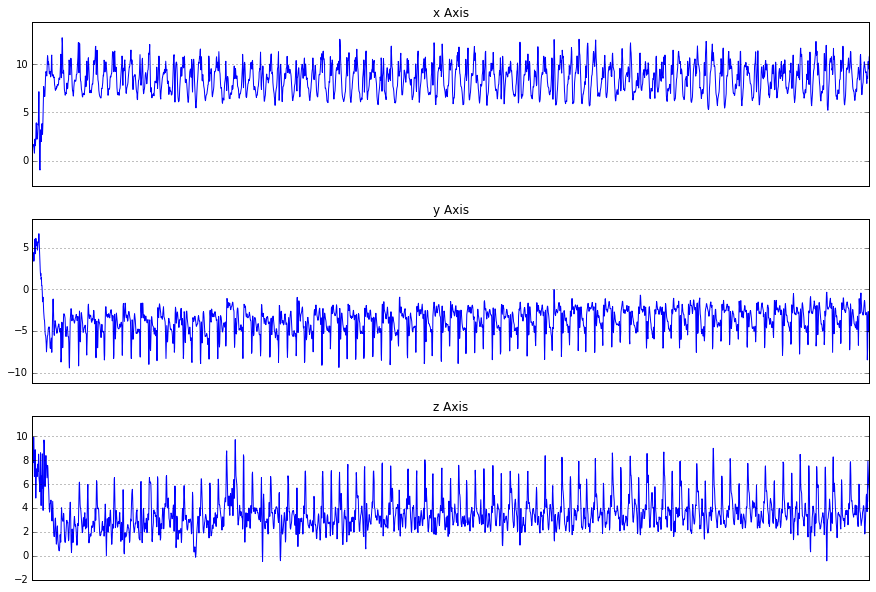

In [4]:
plot_activity(WALKING)

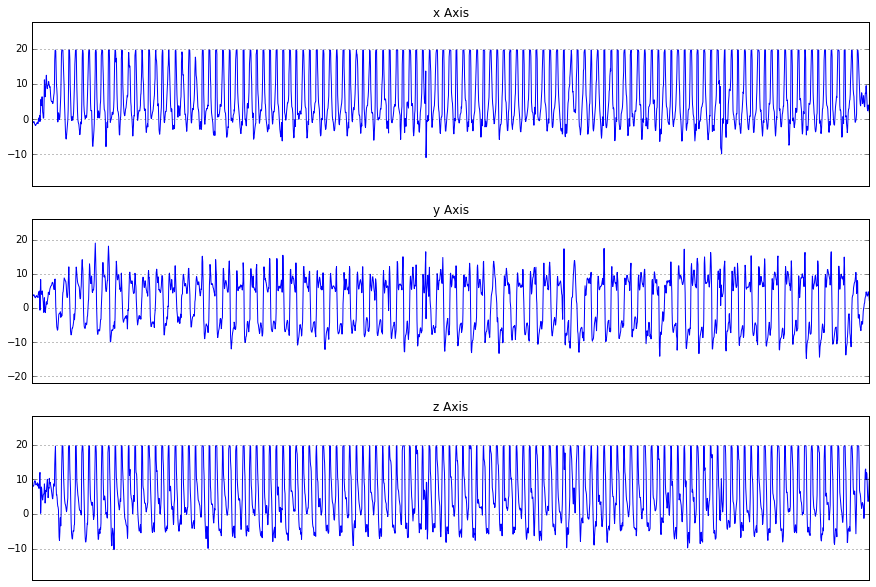

In [5]:
plot_activity(RUNNING)

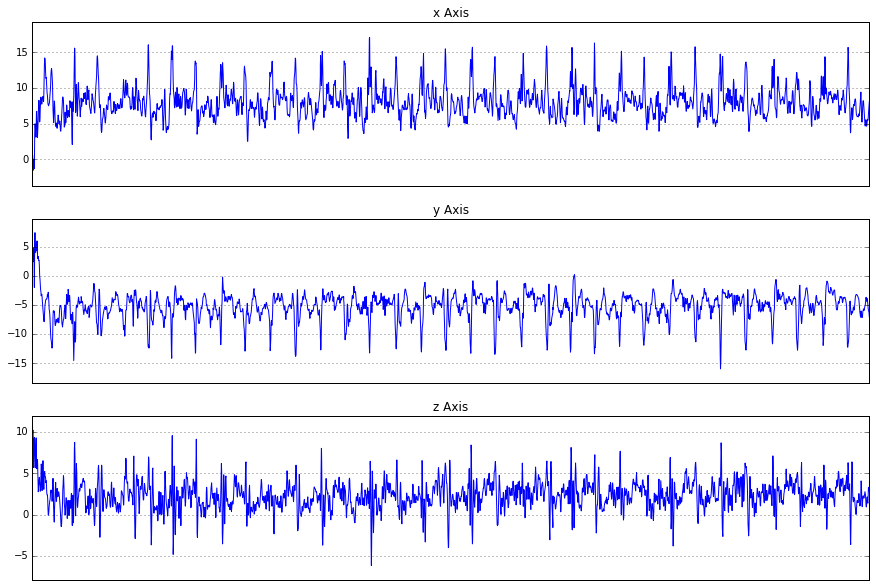

In [6]:
plot_activity(STAIRS)

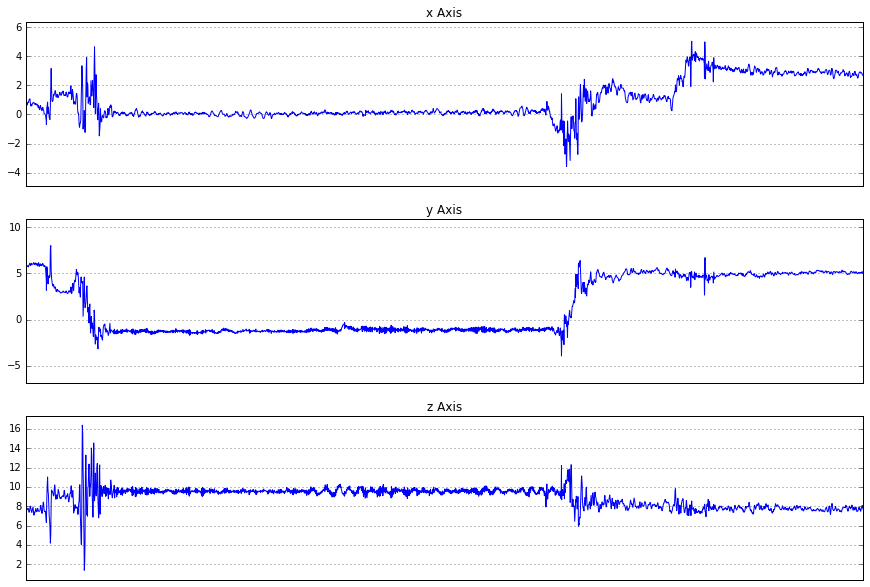

In [7]:
plot_activity(ON_TRAIN)

In [8]:
import math

def magnitude(activity):
    x2 = activity['xAxis'] * activity['xAxis']
    y2 = activity['yAxis'] * activity['yAxis']
    z2 = activity['zAxis'] * activity['zAxis']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

In [9]:
STANDING['magnitude'] = magnitude(STANDING)
WALKING['magnitude'] = magnitude(WALKING)
RUNNING['magnitude'] = magnitude(RUNNING)
STAIRS['magnitude'] = magnitude(STAIRS)
ON_TRAIN['magnitude'] = magnitude(ON_TRAIN)

In [10]:
def plot_magnitudes(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(15, 15))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['magnitude'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()


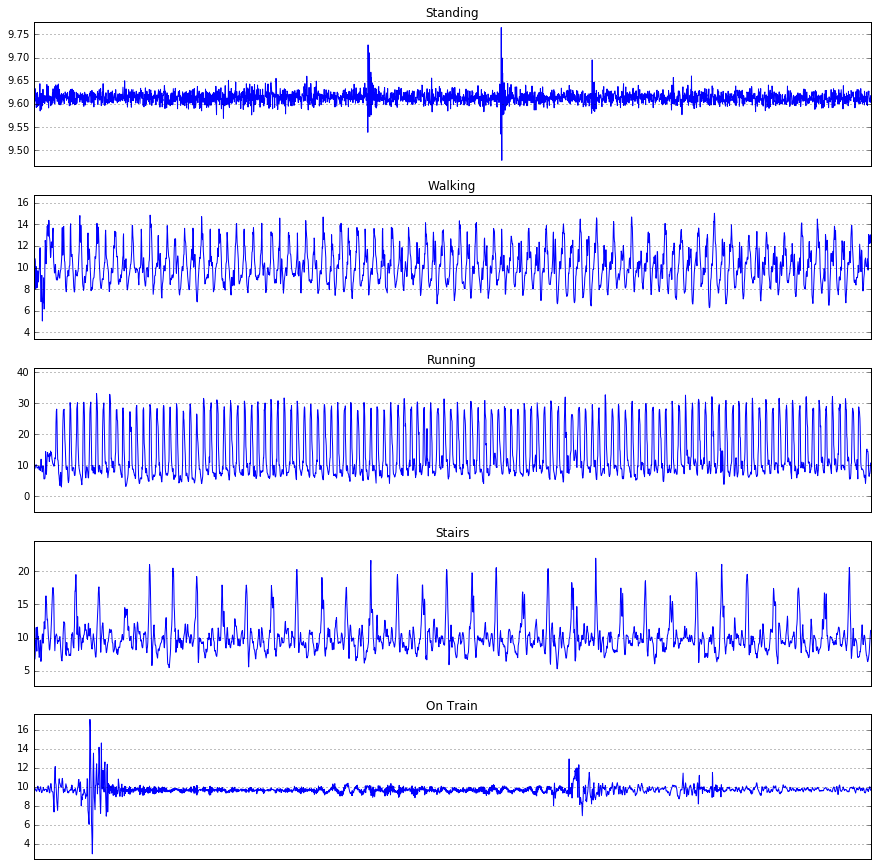

In [11]:
plot_magnitudes([STANDING, WALKING, RUNNING, STAIRS, ON_TRAIN],
               ['Standing', 'Walking', 'Running', 'Stairs', 'On Train'])

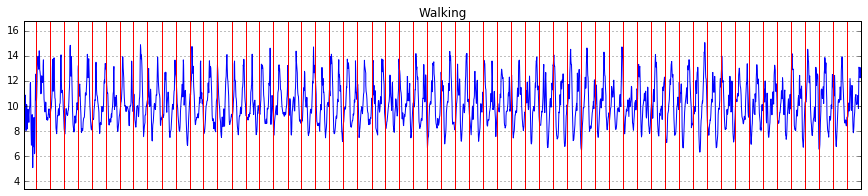

In [14]:
def windows(df, size=100):
    start = 0
    while start < df.count():
        yield start, start + size
        start += (size / 2)

fig, ax = plt.subplots(nrows=1, figsize=(15, 3))
plot_axis(ax, WALKING['timestamp'], WALKING['magnitude'], 'Walking')

for (start, end) in windows(WALKING['timestamp']):
    ax.axvline(WALKING['timestamp'][start], color='r')
    
plt.show()

In [41]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import numpy as np
import math

def jitter(axis, start, end):
    j = float(0)
    for i in xrange(start, min(end, axis.count())):
        if start != 0:
            j += abs(axis[i] - axis[i-1])
    return j / (end-start)

def mean_crossing_rate(axis, start, end):
    cr = 0
    m = axis.mean()
    for i in xrange(start, min(end, axis.count())):
        if start != 0:
            p = axis[i-1] > m
            c = axis[i] > m
            if p != c:
                cr += 1
    return float(cr) / (end-start-1)

def window_summary(axis, start, end):
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        jitter(axis, start, end),     
        mean_crossing_rate(axis, start, end),
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

def features(activity):
    for (start, end) in windows(activity['timestamp']):
        features = []
        for axis in ['xAxis', 'yAxis', 'zAxis', 'magnitude']:
            features += window_summary(activity[axis], start, end)
        yield features

In [43]:
import csv

activities = [STANDING, WALKING, RUNNING, STAIRS, ON_TRAIN]

with open('../Data/Features.csv', 'w') as out:
    rows = csv.writer(out)
    for i in range(0, len(activities)):
        for f in features(activities[i]):
            rows.writerow([i] + f)

In [45]:
dataset = np.loadtxt('../Data/Features.csv', delimiter=",")
X = dataset[:, 1:]
y = dataset[:, 0]

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cross_validation import train_test_split

c = RandomForestClassifier()
b = DummyClassifier() # generates predictions by respecting the training set's class distribution

results = []
baselines = []

for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    c.fit(X_train, y_train)
    b.fit(X_train, y_train)
    res = c.score(X_test, y_test)
    bas = b.score(X_test, y_test)
    print 'Loop', i, res, bas
    results.append(res)
    baselines.append(bas)

print '\nBaseline', np.mean(baselines), np.std(baselines)
print 'Random Forest', np.mean(results), np.std(results)



Loop 0 0.966666666667 0.241666666667
Loop 1 0.991666666667 0.241666666667
Loop 2 0.975 0.191666666667
Loop 3 0.975 0.166666666667
Loop 4 0.983333333333 0.216666666667
Loop 5 0.975 0.208333333333
Loop 6 0.991666666667 0.25
Loop 7 0.975 0.208333333333
Loop 8 1.0 0.216666666667
Loop 9 0.975 0.2

Baseline 0.214166666667 0.0241666666667
Random Forest 0.980833333333 0.00989528507253
